In [14]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from src.model import FashionClassifier
from src.train import train_model
from src.utils import *


In [16]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_data = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FashionClassifier(hidden_sizes=[256, 128], dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_accuracies = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    device,
    epochs=10
)


Epoch 1/10 | Loss: 0.5988 | Val Acc: 0.8346
Epoch 2/10 | Loss: 0.4274 | Val Acc: 0.8589
Epoch 3/10 | Loss: 0.3876 | Val Acc: 0.8656
Epoch 4/10 | Loss: 0.3693 | Val Acc: 0.8640
Epoch 5/10 | Loss: 0.3520 | Val Acc: 0.8680
Epoch 6/10 | Loss: 0.3399 | Val Acc: 0.8714
Epoch 7/10 | Loss: 0.3300 | Val Acc: 0.8748
Epoch 8/10 | Loss: 0.3215 | Val Acc: 0.8790
Epoch 9/10 | Loss: 0.3146 | Val Acc: 0.8774
Epoch 10/10 | Loss: 0.3076 | Val Acc: 0.8858


FileNotFoundError: [Errno 2] No such file or directory: 'results/training_curves.png'

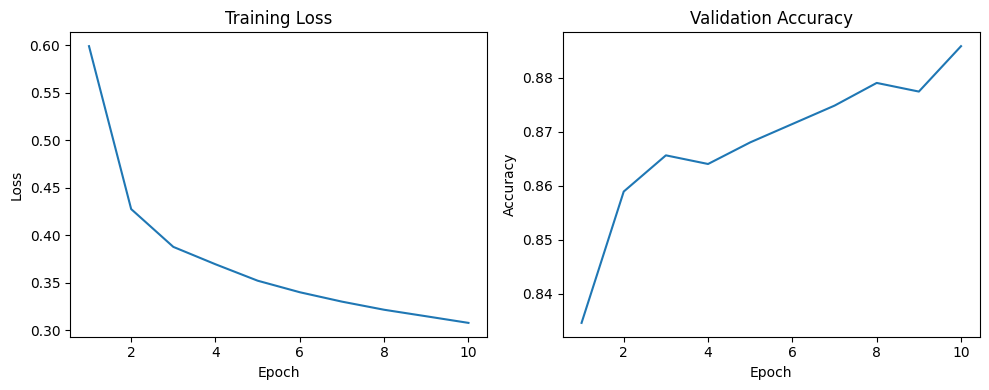

In [18]:
plot_training_curves(
    train_losses,
    val_accuracies,
    "results/training_curves.png"
)


FileNotFoundError: [Errno 2] No such file or directory: 'results/confusion_matrix.png'

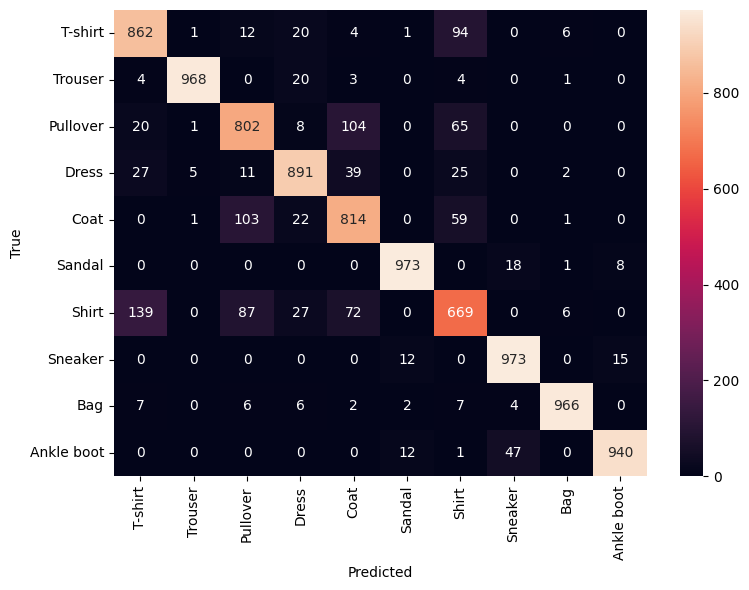

In [19]:
y_pred, y_true, confs = get_predictions(model, test_loader, device)

plot_confusion_matrix(
    y_true,
    y_pred,
    "results/confusion_matrix.png"
)


In [20]:
cost_matrix = np.ones((10, 10))

cost_matrix[6, 0] = 5  # Shirt → T-shirt
cost_matrix[4, 2] = 5  # Coat → Pullover
cost_matrix[5, 7] = 3  # Sandal → Sneaker
cost_matrix[9, 7] = 3  # Ankle boot → Sneaker

cwa = cost_weighted_accuracy(y_true, y_pred, cost_matrix)
print("Cost-weighted accuracy:", cwa)


Cost-weighted accuracy: 0.9010632546404758


FileNotFoundError: [Errno 2] No such file or directory: 'results/confidence_threshold.png'

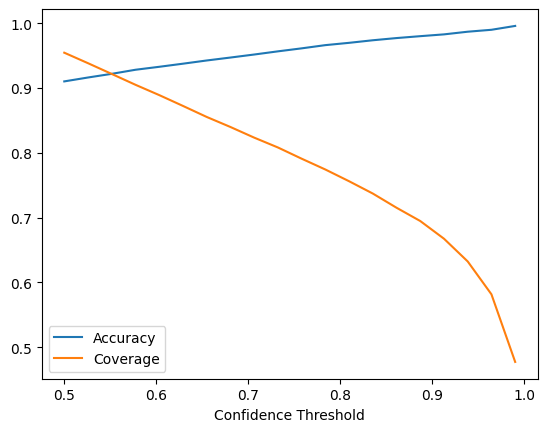

In [21]:
thresholds = np.linspace(0.5, 0.99, 20)
accuracies = []
coverage = []

for t in thresholds:
    mask = confs >= t
    if mask.sum() == 0:
        accuracies.append(0)
        coverage.append(0)
        continue

    acc = (y_pred[mask] == y_true[mask]).mean()
    accuracies.append(acc)
    coverage.append(mask.mean())

plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, coverage, label="Coverage")
plt.legend()
plt.xlabel("Confidence Threshold")
plt.savefig("results/confidence_threshold.png")
plt.close()
